#**Proyecto Text Mining - grupo 8**


















# Parte 1. Preparación de texto 

In [ ]:
# Instalación paquetes o dependencias
!pip install -U imbalanced-learn
!pip install nltk
!pip install pyspark
!pip install pyLDAvis

#configuración en google colab de spark y pyspark
from google.colab import drive
drive.mount('/content/gdrive')

#Importar librerias necesarias
import pandas as pd
import numpy as np

#Librerias para gráficas y visulización
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
%matplotlib inline

#Sesión Pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
#forma 1 de crear la sesión y el contexto Spark:
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

##!pip install langdetect
from langdetect import detect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [ ]:
#Ingesta de datos
df=pd.read_csv('/content/gdrive/MyDrive/st1800-trabajo23-2266/dataset/twitterClimateData.csv', sep=";", encoding = 'utf8')

# 1.1 Análisis exploratorio 

In [ ]:
### Primeros datos 
df.head()

Unnamed: 0        id     author_id  \
0           0  1,21E+23      7.59e+17   
1           1  1,21E+23    22195472.0   
2           2  1,21E+23      1.07e+18   
3           3  1,21E+23  1339821457.0   
4           4  1,21E+23  1339821457.0   

                                                text  retweets  \
0  2020 is the year we #votethemout, the year we ...        15   
1  Winter has not stopped this group of dedicated...         9   
2  WEEK 55 of #ClimateStrike at the @UN. Next wee...       545   
3  A year of resistance, as youth protests shaped...         1   
4   HAPPY HOLIDAYS #greta #gretathunberg #climate...         1   

                                           permalink  \
0  https://twitter.com/Sphiamia/status/1211807074...   
1  https://twitter.com/StephDujarric/status/12106...   
2  https://twitter.com/AlexandriaV2005/status/121...   
3  https://twitter.com/EnergyHouseVA/status/12102...   
4  https://twitter.com/EnergyHouseVA/status/12096...   

                        date                  formatted_date  favorites  \
0  2019-12-31 00:31:35+00:00  Tue Dec 31 00:31:35 +0000 2019         46   
1  2019-12-27 20:56:21+00:00  Fri Dec 27 20:56:21 +0000 2019         35   
2  2019-12-27 15:50:22+00:00  Fri Dec 27 15:50:22 +0000 2019       3283   
3  2019-12-26 17:53:26+00:00  Thu Dec 26 17:53:26 +0000 2019          2   
4  2019-12-25 00:56:37+00:00  Wed Dec 25 00:56:37 +0000 2019          4   

              mentions                                           hashtags  \
0                  NaN          #votethemout #climatestrike #rebelforlife   
1                  NaN       #climatefriday #climatestrike #ClimateAction   
2  @UN @Fridays4future                                     #ClimateStrike   
3                  NaN  #greta #gretathunberg #climatechange #fridaysf...   
4                  NaN  #greta #gretathunberg #climatechange #fridaysf...   

   geo                                               urls search_hashtags  \
0  NaN                                                NaN  #climatestrike   
1  NaN                                                NaN  #climatestrike   
2  NaN                                                NaN  #climatestrike   
3  NaN  https://www.channelnewsasia.com/news/commentar...  #climatestrike   
4  NaN  http://www.energyhouse.us,http://www.pacenowfo...  #climatestrike   

          location  
0  California, USA  
1  California, USA  
2  California, USA  
3  California, USA  
4  California, USA

In [ ]:
# Validación de datos faltantes 
df.count()

Unnamed: 0         72405
id                 72405
author_id          72405
text               72405
retweets           72405
permalink          72405
date               72405
formatted_date     72405
favorites          72405
mentions           27554
hashtags           72402
geo                    0
urls               33349
search_hashtags    72405
location           72405
dtype: int64

Solo 3 variables tienen datos incompletos, sin embargo, estas variables no son relevantes para el análisis.

In [ ]:
#Selección de variables requeridas para el análisis 
col=['text','search_hashtags']
df2=df[col]
df2.head()

text search_hashtags
0  2020 is the year we #votethemout, the year we ...  #climatestrike
1  Winter has not stopped this group of dedicated...  #climatestrike
2  WEEK 55 of #ClimateStrike at the @UN. Next wee...  #climatestrike
3  A year of resistance, as youth protests shaped...  #climatestrike
4   HAPPY HOLIDAYS #greta #gretathunberg #climate...  #climatestrike

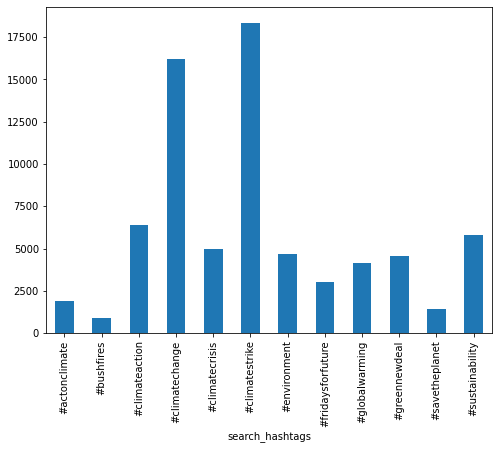

In [ ]:
#Análisis gráfico de labels
fig = plt.figure(figsize=(8,6))
df2.groupby('search_hashtags').search_hashtags.count().plot.bar(ylim=0)
plt.show()

In [ ]:
#Número de datos en cada label 
print(df2.shape)
print(pd.value_counts(df2['search_hashtags'], sort = True))

(72405, 2)
#climatestrike       18355
#climatechange       16190
#climateaction        6378
#sustainability       5790
#climatecrisis        4982
#environment          4703
#greennewdeal         4589
#globalwarming        4152
#fridaysforfuture     3038
#actonclimate         1895
#savetheplanet        1434
#bushfires             899
Name: search_hashtags, dtype: int64


In [ ]:
#Porcentaje de cada uno de los hastags respecto al total de hashtags
total=df.shape[0]
x=(df2.groupby('search_hashtags').search_hashtags.count()/total)*100
print(x)

search_hashtags
#actonclimate         2.617223
#bushfires            1.241627
#climateaction        8.808784
#climatechange       22.360334
#climatecrisis        6.880740
#climatestrike       25.350459
#environment          6.495408
#fridaysforfuture     4.195843
#globalwarming        5.734411
#greennewdeal         6.337960
#savetheplanet        1.980526
#sustainability       7.996685
Name: search_hashtags, dtype: float64


Se identifica tras el análisis gráfico y tras realizar una medida de participación los labels en el dataset que se encuentran desbalancedados

# 1.2 Tokenización/Normalización


In [ ]:
#Configuración PySpark
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"
import findspark
findspark.init()

In [ ]:
#Librerías para tokenizar y preparar texto
import nltk
import operator
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from nltk.tokenize import TweetTokenizer
import re
nltk.download('punkt')
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#detección de tipo de lenguaje 
df2['language'] = df2['text'].apply(lambda x: detect(x))
pd.DataFrame(df2.groupby('language').text.count().sort_values(ascending=False))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


text
language       
en        66886
fr         1580
es         1040
et          612
id          418
de          389
ro          257
nl          255
hi          179
it          141
tl           96
af           88
no           71
pt           51
sv           42
da           42
sl           36
ca           29
fi           26
mr           24
tr           23
hr           23
ru           18
sq           14
so            8
he            7
el            6
ar            5
mk            4
lt            4
uk            4
gu            3
pl            3
sw            3
te            2
vi            2
zh-cn         2
ne            2
ja            2
hu            2
cy            2
bg            2
ur            1
lv            1

In [ ]:
#Filtro de registros que se encuentran en idioma ingles
df3 = df2.query("language == 'en'")
df3.groupby('language').search_hashtags.count().head()


language
en    66886
Name: search_hashtags, dtype: int64

In [ ]:
df3.reset_index()

index                                               text  \
0          0  2020 is the year we #votethemout, the year we ...   
1          1  Winter has not stopped this group of dedicated...   
2          2  WEEK 55 of #ClimateStrike at the @UN. Next wee...   
3          3  A year of resistance, as youth protests shaped...   
4          4   HAPPY HOLIDAYS #greta #gretathunberg #climate...   
...      ...                                                ...   
66881  72400  No more straws at LBM... only if YOU ask for i...   
66882  72401  My #Trumps may not believe in #climatechange b...   
66883  72402  Time is over. Act now!!! #Friday4Future #Clima...   
66884  72403  This is my first contribution on visualizing t...   
66885  72404  "This assault on science is an outrage and sho...   

      search_hashtags language  
0      #climatestrike       en  
1      #climatestrike       en  
2      #climatestrike       en  
3      #climatestrike       en  
4      #climatestrike       en  
...               ...      ...  
66881  #savetheplanet       en  
66882  #savetheplanet       en  
66883  #savetheplanet       en  
66884  #savetheplanet       en  
66885  #savetheplanet       en  

[66886 rows x 4 columns]

In [ ]:
#Validar cantidad de registros en labels
print(df3.shape)
print(pd.value_counts(df3['search_hashtags'], sort = True))

(66886, 3)
#climatestrike       16009
#climatechange       15338
#climateaction        6014
#sustainability       5634
#climatecrisis        4827
#greennewdeal         4387
#environment          4339
#globalwarming        3833
#fridaysforfuture     2531
#actonclimate         1847
#savetheplanet        1240
#bushfires             887
Name: search_hashtags, dtype: int64


In [ ]:
#Validar porcentaje de registros en cada label 
total=df3.shape[0]
print(total)
x=(df3.groupby('search_hashtags').search_hashtags.count()/total)*100
print(x)

66886
search_hashtags
#actonclimate         2.761415
#bushfires            1.326137
#climateaction        8.991418
#climatechange       22.931555
#climatecrisis        7.216757
#climatestrike       23.934755
#environment          6.487157
#fridaysforfuture     3.784050
#globalwarming        5.730646
#greennewdeal         6.558921
#savetheplanet        1.853901
#sustainability       8.423287
Name: search_hashtags, dtype: float64




Se comparó el porcentaje de los hastags de los twitts solo en ingles y de el total de twitts, estos porcentajes no tuvieron gran variación.



In [ ]:
##Limpieza de datos y creación de category_id
from io import StringIO
col = ['text', 'search_hashtags']
df4 = df3[col]
df4.columns = ['text', 'search_hashtags']
df4['category_id'] = df4['search_hashtags'].factorize()[0]
category_id_df4 = df4[['search_hashtags', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df4.values)
id_to_category = dict(category_id_df4[['category_id', 'search_hashtags']].values)
df4.head()

text search_hashtags  \
0  2020 is the year we #votethemout, the year we ...  #climatestrike   
1  Winter has not stopped this group of dedicated...  #climatestrike   
2  WEEK 55 of #ClimateStrike at the @UN. Next wee...  #climatestrike   
3  A year of resistance, as youth protests shaped...  #climatestrike   
4   HAPPY HOLIDAYS #greta #gretathunberg #climate...  #climatestrike   

   category_id  
0            0  
1            0  
2            0  
3            0  
4            0

In [ ]:
df4.head(3000)

text search_hashtags  \
0     2020 is the year we #votethemout, the year we ...  #climatestrike   
1     Winter has not stopped this group of dedicated...  #climatestrike   
2     WEEK 55 of #ClimateStrike at the @UN. Next wee...  #climatestrike   
3     A year of resistance, as youth protests shaped...  #climatestrike   
4      HAPPY HOLIDAYS #greta #gretathunberg #climate...  #climatestrike   
...                                                 ...             ...   
3158  “When I think of my two daughters, I know I ca...  #climatechange   
3159  …@realDonaldTrump behaves like a spoiled child...  #climatechange   
3160  Let’s hope we get some divine intervention. An...  #climatechange   
3161  My PI @kgedan featured in @nytimes article on ...  #climatechange   
3162  Admiral Richardson said #ClimateChange is in s...  #climatechange   

      category_id  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
3158            1  
3159            1  
3160            1  
3161            1  
3162            1  

[3000 rows x 3 columns]

In [ ]:
#Configurar stop words en ingles
stop_words_nltk = set(stopwords.words('english'))


1.2.1 Tokenización con tokenizador clásico 

In [ ]:
#Función que limpia y tokeniza las palabras de cada twit
def textprep(record):
    text  = record
    tokens = text.split()
    # Custom List of Stopwords - Add your own here
    tokens = [re.sub('[^a-zA-Z0-9#]','',word) for word in tokens]
    tokens = [re.sub('http\S+', '', word) for word in tokens]
    tokens = [word.lower() for word in tokens if len(word)>2 and word.lower() not in stop_words_nltk]
    return tokens


#Código tomado y adaptado de: https://github.com/st1800eafit/st1800-2266/tree/main/text-prep/lab9-airlines-pyspark.ipynb

<>:7: DeprecationWarning: invalid escape sequence \S
<>:7: DeprecationWarning: invalid escape sequence \S
<>:7: DeprecationWarning: invalid escape sequence \S
<ipython-input-262-5699e7212f7c>:7: DeprecationWarning: invalid escape sequence \S
  tokens = [re.sub('http\S+', '', word) for word in tokens]


In [ ]:
text=df3['text']
tokens_list=[]
for twitt in text:
  tokens_list.append(textprep(twitt))

In [ ]:
#Creación bag of word
bow={}
for twitt in tokens_list:
  for token in twitt:
    if token in bow:
      bow[token] += 1
    else:
      bow[token] = 1
print(bow)

{'2020': 295, 'year': 929, '#votethemout': 30, '#climatestrike': 19778, 'hearts': 19, '#rebelforlife': 62, 'without': 429, 'liveable': 25, 'future': 2574, 'nothing': 441, 'else': 244, 'matters': 163, 'get': 2014, 'shit': 135, 'done': 538, 'winter': 140, 'stopped': 75, 'group': 288, 'dedicated': 184, 'climate': 9345, 'activists': 467, 'example': 202, 'follow': 421, '#climatefriday': 54, '#climateaction': 10353, 'week': 952, 'next': 1016, 'fridays4future': 172, 'heads': 63, '3rd': 89, 'striking': 315, 'time': 2773, 'streets': 419, 'gets': 220, 'longer': 210, 'need': 3306, 'act': 1065, 'something': 664, 'people': 4455, 'must': 1174, 'stop': 1050, 'looking': 469, 'away': 366, 'pretending': 20, 'crisis': 1212, 'doesnt': 493, 'exist': 89, 'united': 1343, 'nations': 823, 'resistance': 32, 'youth': 1545, 'protests': 213, 'shaped': 18, 'change': 5116, 'discussions': 94, 'active': 81, 'vote': 511, '#greta': 141, '#gretathunberg': 1190, '#climatechange': 22324, '#fridaysforfuture': 5351, '#kickas

In [ ]:
#Tamaño del Bag of words
print(len(bow))

78864


In [ ]:
#Ordenar bag of word
bow_sort = dict(sorted(bow.items(), key=operator.itemgetter(1), reverse=True))
print(bow_sort)

{'#climatechange': 22324, '#climatestrike': 19778, '#climateaction': 10353, 'climate': 9345, '#climatecrisis': 7701, 'amp': 6823, '#sustainability': 6628, '#environment': 5675, '#greennewdeal': 5515, '#fridaysforfuture': 5351, 'change': 5116, '#globalwarming': 4792, 'people': 4455, 'today': 4189, 'new': 3389, 'need': 3306, 'world': 3120, 'gretathunberg': 2937, '#climateemergency': 2922, 'action': 2921, 'time': 2773, '#actonclimate': 2653, 'like': 2642, 'future': 2574, 'one': 2523, 'planet': 2475, 'day': 2102, 'great': 2082, 'global': 2079, 'see': 2029, 'get': 2014, 'dont': 1962, 'take': 1891, '#climatechangeisreal': 1873, 'young': 1813, 'make': 1798, '#savetheplanet': 1722, 'students': 1709, 'city': 1643, '#climateactionnow': 1627, 'thank': 1596, 'youth': 1545, 'join': 1528, 'support': 1523, 'work': 1490, '#climate': 1481, 'strike': 1481, '#auspol': 1432, 'want': 1371, 'good': 1369, 'earth': 1358, 'going': 1352, 'united': 1343, 'way': 1343, 'many': 1332, 'energy': 1316, 'save': 1315, '

In [ ]:
#primeros N datos bag of words
firstn=10
bow_graph= {n: bow_sort[n] for n in list(bow_sort)[:firstn]}
print(bow_graph)

{'#climatechange': 22324, '#climatestrike': 19778, '#climateaction': 10353, 'climate': 9345, '#climatecrisis': 7701, 'amp': 6823, '#sustainability': 6628, '#environment': 5675, '#greennewdeal': 5515, '#fridaysforfuture': 5351}


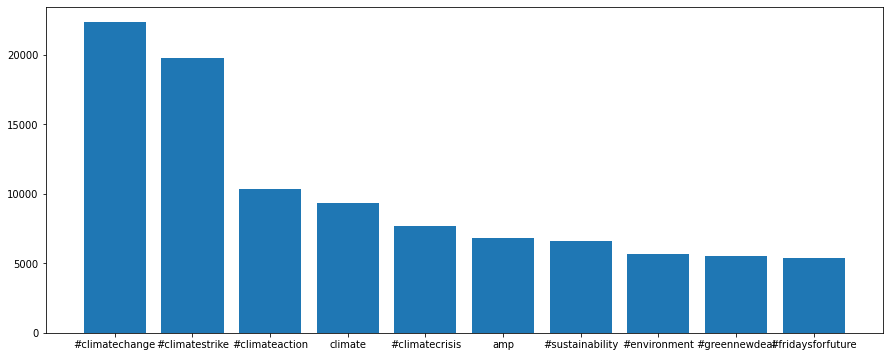

78864


In [ ]:
TopN=bow_graph.items()
x, y = zip(*TopN)
plt.figure(figsize=(15,6))
plt.bar(x, y)
plt.show()
print(len(bow))

1.2.2 Tokenizacion con tokenizador especial para datos de twitter


In [ ]:
!python -m spacy download fr_core_news_sm

2022-10-03 00:59:57.418966: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.3 MB 128 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [ ]:
from nltk.tokenize import TweetTokenizer
from gensim.utils import simple_preprocess
import spacy

In [ ]:
#Tokenizacion de texto 
text=df4['text']
tweet_tokenizer = TweetTokenizer()
tweet_tokens = []
for sent in text:
    tweet_tokenizer.tokenize(sent)
    tweet_tokens.append(tweet_tokenizer.tokenize(sent))



In [ ]:
print(tweet_tokens[1])

['Winter', 'has', 'not', 'stopped', 'this', 'group', 'of', 'dedicated', 'climate', 'activists', '.', 'They', 'are', 'an', 'example', 'to', 'follow', '.', '#climatefriday', '#climatestrike', '#ClimateAction']


In [ ]:
### Tamaño del BoW 
print(len(tweet_tokens))

66886


El tamaño del BoW con esta técnica tine una dimensión menor 


In [ ]:
#Función para normalizar datos
def textprep2(tokens):
    # Custom List of Stopwords - Add your own here
    tokens = [re.sub('[^a-zA-Z#]','',word) for word in tokens]
    tokens = [re.sub('http\S+', '', word) for word in tokens]
    #tokens = [word.lower() for word in tokens if len(word)>2 and word.lower() not in stop_words_nltk]
    return tokens

<>:5: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \S
<>:5: DeprecationWarning: invalid escape sequence \S
<ipython-input-274-06acc3c0ac84>:5: DeprecationWarning: invalid escape sequence \S
  tokens = [re.sub('http\S+', '', word) for word in tokens]


In [ ]:
tweet_text = []
for twitt in tweet_tokens:
 tweet_text.append(textprep2(twitt))

In [ ]:
tweet_text[1]

['Winter', 'has', 'not', 'stopped', 'this', 'group', 'of', 'dedicated', 'climate', 'activists', '', 'They', 'are', 'an', 'example', 'to', 'follow', '', '#climatefriday', '#climatestrike', '#ClimateAction']

In [ ]:
# Construcción de bigrams y trigrams
bigram = gensim.models.Phrases(tweet_text, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tweet_text], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[tweet_text[1000]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['When', 'the', 'planet', 'we', 'love', 'is', 'under_attack_STAND_UP', 'FIGHT_BACK_Will', 'you', 'join', 'the', 'fight', 'as', 'people', 'across', 'the', 'world', 'take', 'to', 'the', 'streets', 'starting', 'Sept', 'for', 'a', 'week', 'of', 'global', '#socialwork_#MacroSW', '#climatestrike', '#StrikeWithUs']


In [ ]:
nlp = spacy.load('fr_core_news_sm')

In [ ]:
#Función para remoción de stopwords, creación de bigram y trigrams
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_nltk] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remoción de stopwords
data_words_nostops = remove_stopwords(tweet_text)

# Creación de bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Lematización
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['year', 'votethemout', 'year', 'climatestrike', 'hearts', 'year', 'rebelforlife', 'without', 'liveabl', 'future', 'nothing_else', 'matter', 'year', 'get', 'shit', 'don']]


In [ ]:
#Creación del BoW
bow2={}
for twitt in data_lemmatized:
  for token in twitt:
    if token in bow2:
      bow2[token] += 1
    else:
      bow2[token] = 1
print(bow2)

{'year': 1707, 'votethemout': 35, 'climatestrike': 16557, 'hearts': 6, 'rebelforlife': 10, 'without': 406, 'liveabl': 26, 'future': 1353, 'nothing_else': 17, 'matter': 424, 'get': 1306, 'shit': 139, 'don': 80, 'winter': 220, 'stopped': 66, 'group': 337, 'activist': 707, 'example': 203, 'follow': 476, 'climatefriday': 54, 'climateaction': 10417, 'week': 1035, 'next': 872, 'fridaysfuture': 61, 'head': 160, 'striking': 219, 'time': 2756, 'street': 710, 'longer': 200, 'need': 3512, 'act': 698, 'something': 668, 'climate': 6068, 'people': 4055, 'must': 1176, 'doesnt': 180, 'exist': 96, 'united': 1335, 'natier': 329, 'resistance': 66, 'youth': 1526, 'protests_shaped': 9, 'chang': 2735, 'discussion': 385, 'active': 25, 'vote': 500, 'greta': 732, 'gretathunberg': 4006, 'climatechang': 2584, 'kickas': 32, 'climat': 3660, 'thwave': 18, 'love': 611, 'bhfyp': 68, 'happy': 641, 'holiday': 123, 'energy': 1170, 'hous': 1026, 'team': 468, 'virginier': 185, 'washingtondc': 141, 'question': 572, 'ask': 

In [ ]:
#Tamaño del BoW
print(len(bow2))

55234


In [ ]:
bow2_sort = dict(sorted(bow2.items(), key=operator.itemgetter(1), reverse=True))
print(bow2_sort)

{'climatechange': 19826, 'climatestrike': 16557, 'climateaction': 10417, 'climatecrisi': 7750, 'sustainability': 6933, 'climate': 6068, 'environmer': 5435, 'greennewdeal': 5409, 'today': 4883, 'globalwarming': 4484, 'people': 4055, 'gretathunberg': 4006, 'climat': 3660, 'need': 3512, 'action': 3265, 'time': 2756, 'chang': 2735, 'planet': 2723, 'climatechang': 2584, 'world': 2560, 'change': 2277, 'new': 2272, 'actonclimat': 2236, 'great': 2079, 'like': 1979, 'student': 1959, 'one': 1954, 'day': 1885, 'young': 1780, 'global': 1732, 'year': 1707, 'support': 1649, 'youth': 1526, 'auspol': 1496, 'savetheplanet': 1489, 'nature': 1411, 'good': 1386, 'water': 1374, 'sav': 1367, 'join': 1364, 'green': 1360, 'thank': 1355, 'wer': 1355, 'future': 1353, 'school': 1339, 'united': 1335, 'right': 1307, 'get': 1306, 'fight': 1282, 'science': 1257, 'leader': 1236, 'bushfire': 1225, 'part': 1207, 'help': 1206, 'think': 1187, 'real': 1183, 'must': 1176, 'live': 1171, 'energy': 1170, 'impact': 1148, 'capi

In [ ]:
firstn=10
bow2_graph= {n: bow2_sort[n] for n in list(bow2_sort)[:firstn]}
print(bow2_graph)

{'climatechange': 19826, 'climatestrike': 16557, 'climateaction': 10417, 'climatecrisi': 7750, 'sustainability': 6933, 'climate': 6068, 'environmer': 5435, 'greennewdeal': 5409, 'today': 4883, 'globalwarming': 4484}


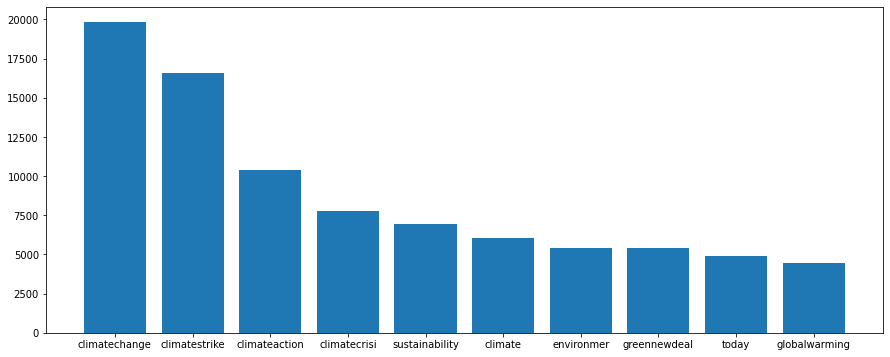

55234


In [ ]:
TopN=bow2_graph.items()
x, y = zip(*TopN)
plt.figure(figsize=(15,6))
plt.bar(x, y)
plt.show()
print(len(bow2))

Se reduce la dimensionalidad del BoW a 55254

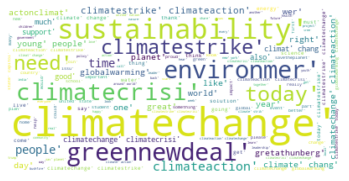

In [ ]:
#Nube de palabras 
str1=" "
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(str1.join(str(e) for e in data_lemmatized))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

1.2 Vector de características 

In [ ]:
import pyspark

In [ ]:
# Vector de caractristicas con CountVectorizer 
df5=  pd.DataFrame(np.array(data_lemmatized), columns=['words'])
df6 = df5.assign(category_id=df4['category_id'])
df7 = sqlContext.createDataFrame(df6)
cv = CountVectorizer(inputCol="words", outputCol="rawFeatures")
cvmodel = cv.fit(df7)
featurizedData = cvmodel.transform(df7)

vocab = cvmodel.vocabulary
vocab_broadcast = sc.broadcast(vocab)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
df8 = idfModel.transform(featurizedData)
df8.show(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


+--------------------+-----------+--------------------+--------------------+
|               words|category_id|         rawFeatures|            features|
+--------------------+-----------+--------------------+--------------------+
|[year, votethemou...|        0.0|(55234,[1,30,43,4...|(55234,[1,30,43,4...|
|[winter, stopped,...|        0.0|(55234,[1,2,117,1...|(55234,[1,2,117,1...|
|[week, climatestr...|        0.0|(55234,[1,5,10,13...|(55234,[1,5,10,13...|
|[year, resistance...|        0.0|(55234,[5,11,12,1...|(55234,[5,11,12,1...|
|[happy, holiday, ...|        0.0|(55234,[1,5,11,18...|(55234,[1,5,11,18...|
+--------------------+-----------+--------------------+--------------------+
only showing top 5 rows



1.2.3 Creación de vector de caracterísitcas

In [ ]:
# Crear diccionario
id2word = corpora.Dictionary(data_lemmatized)

# Crear corpus
texts = data_lemmatized

#TF 
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 4)]]


In [ ]:
len(corpus)

66886

Se emplean dos métodos para la creación del vector de caractrísticas: el CountVectorizer y id2word

# Parte 2. Detección de Tópicos y Modelo LDA 

Validación de K óptimo


In [ ]:
#Librerías gensim
from gensim.models import CoherenceModel
import gensim.corpora as corpora

*la siguientes lineas de código fueron adaptadas y tomadas: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda .
las lineas de código son:


1.   Mallet
2.   K-óptimo
3.   Valores de coherencia
4.   asignación de tópicos





In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2022-10-03 01:12:19--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-10-03 01:12:19--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.1’

mallet-2.0.8.zip.1  100%[===================>]  15.43M  16.1MB/s    in 1.0s    

2022-10-03 01:12:20 (16.1 MB/s) - ‘mallet-2.0.8.zip.1’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace mallet-2.0.8/bin/csv2classify? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace

In [ ]:
mallet_path = "/content/mallet-2.0.8/bin/mallet"

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Número intutivo de tópicos

In [ ]:
n_topicos = pd.unique(df["search_hashtags"])
len(n_topicos)

12

In [ ]:
#Modelo para hallar el k optimo
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=len(n_topicos), step=2)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

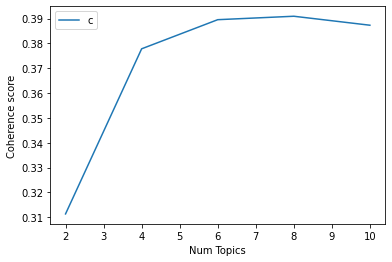

In [ ]:
limit=12; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3113
Num Topics = 4  has Coherence Value of 0.3778
Num Topics = 6  has Coherence Value of 0.3896
Num Topics = 8  has Coherence Value of 0.3909
Num Topics = 10  has Coherence Value of 0.3873


Se define el k óptimo en 8 tópicos según los resultados del módelo 

Tópicos con mallet 

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
# Show Topics
print(ldamallet.show_topics(formatted=False))

In [ ]:
print(ldamallet.show_topics(formatted=False))

In [ ]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

Tópicos con modelo gensim clásiso 

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sco

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Se definen los tópicos con método gensim clásico y mallet y se determina que mallet tiene un Score Coherence más alto 

Visualización de tópicos 


In [ ]:
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [ ]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

In [ ]:
def convertldaGenToldaMallet(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

optimal_model = convertldaGenToldaMallet(optimal_model)

In [ ]:
lda_viz = gensimvis.prepare(optimal_model, corpus, id2word)
lda_viz 

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.150840  0.082096       1        1  12.744000
3     -0.055713 -0.332579       2        1  12.554277
4     -0.094402 -0.235793       3        1  12.547687
7      0.310854  0.057920       4        1  12.525433
5     -0.011058  0.039983       5        1  12.491895
6     -0.205382  0.150455       6        1  12.436776
1     -0.104993  0.214118       7        1  12.393250
2      0.311533  0.023800       8        1  12.306682, topic_info=                Term          Freq         Total Category  logprob  loglift
0      climatestrike  17733.000000  17733.000000  Default  30.0000  30.0000
89     climatechange  21945.000000  21945.000000  Default  29.0000  29.0000
69    sustainability   7667.000000   7667.000000  Default  28.0000  28.0000
14     climateaction  11142.000000  11142.000000  Default  27.0000  27.0000
167     greennewdeal   5971.000000   5971.000000  Default  26.0000  26.0000
...              ...           ...           ...      ...      ...      ...
731          morning    487.364630    595.251203   Topic8  -5.2803   1.8951
14     climateaction   1441.697573  11142.655905   Topic8  -4.1958   0.0501
1170          friend    457.306903    590.088564   Topic8  -5.3440   1.8401
137            futur    502.393494    987.044114   Topic8  -5.2500   1.4197
2             future    524.936767   1448.010750   Topic8  -5.2061   1.0804

[532 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
909       4  0.999436     acros
21        5  1.000478       act
95        4  1.000129    action
39        4  1.018675    active
13        4  1.000585  activist
...     ...       ...       ...
173       4  0.999364     young
173       5  0.000530     young
53        4  0.521659     youth
53        8  0.478033     youth
70        2  1.002095  zerowast

[600 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 8, 6, 7, 2, 3])

Asignación de tópicos a dataset inicial

In [ ]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=text):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=text)

# Show
df_topic_sents_keywords

Gráfica y función de asignación de tópicos tomadas de:https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda
El aporte del equipo en esta función fue reestructurar parte del código tanto en sus parametros de entrada como de salida para poder tener una asignación de tópicos correcta.

# Parte 3. Clasificadores - modelos supervisados 

Código tomado y adaptado de:https://github.com/st1800eafit/st1800-2266/tree/main/text-mining/classifier-nb

3.1 Clasificador Naive Bayes con labels predeterminados


In [ ]:
#Clasificador Naive Bayes
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

import pickle

X_train, X_test, y_train, Y_test = train_test_split(df['text'], df['search_hashtags'], random_state = 0)

count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)





In [ ]:
salida= []
for x in X_test:
    salida.append(clf.predict(count_vect.transform([x]))[0])

In [ ]:
salida

Graficación matriz de  confusión tomada de:
https://www.aprendemachinelearning.com/clasificacion-con-datos-desbalanceados/
Se adapta el código para trabajar con la *salida* creada

In [ ]:
#matriz de confusión
from sklearn import metrics
from sklearn.calibration import CalibrationDisplay
cMatrix = metrics.confusion_matrix(Y_test, salida)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cMatrix, display_labels = np.unique(Y_test))
cm_display.plot(xticks_rotation=90, cmap='Blues')
plt.show()

In [ ]:
# Métricas para evaluar desempeño del clasificador 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

accuracy=accuracy_score(Y_test,salida).round(2)
precision=precision_score(Y_test,salida,average='macro').round(2)
recall=recall_score(Y_test,salida,average='macro')
F1_score=f1_score(Y_test,salida,average='macro').round(2)
models_scores_table = pd.DataFrame({'clf_name':[accuracy,precision,
                                                  recall,
                                                  F1_score]
                                         },
                                       index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

models_scores_table

3.2 Modelo alternativo: regresión logística con labels predeterminados 
 

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#creamos una función que crea el modelo que usaremos cada vez
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0, penalty='l2',random_state=1,solver="newton-cg", class_weight="balanced")
    clf_base.fit(X_train_tfidf, y_train)
    return clf_base
 
model = run_model(X_train_tfidf, X_test, y_train, Y_test)
 

In [ ]:
predict_rl= []
for x in X_test:
    predict_rl.append(model.predict(count_vect.transform([x]))[0])

In [ ]:
cMatrix_rg = metrics.confusion_matrix(Y_test, predict_rl)
cm_display_rg = metrics.ConfusionMatrixDisplay(confusion_matrix = cMatrix_rg, display_labels = np.unique(Y_test))
cm_display_rg.plot(xticks_rotation=90, cmap='Blues')
plt.show()

In [ ]:
accuracy_rl=accuracy_score(Y_test,predict_rl).round(2)
precision_rl=precision_score(Y_test,predict_rl,average='macro').round(2)
recall_rl=recall_score(Y_test,predict_rl,average='macro')
F1_score_rl=f1_score(Y_test,predict_rl,average='macro').round(2)
models_scores_table = pd.DataFrame({'clf_name':[accuracy_rl,precision_rl,
                                                  recall_rl,
                                                  F1_score_rl]
                                         },
                                       index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

models_scores_table

Tras validar las métricas de desempeño se determina que la regresión logística tiene mejor rendimiento a la hora de clasificar el texto con los labels predeterminados. Para el modelo de regresión logística se ajusta los pesos de los labels para ajustar el desbalance entontrado. 

3.3 Clasificador Naive Bayes con labels= tópicos

In [ ]:
X_train, X_test, y_train, Y_test = train_test_split(df_topic_sents_keywords['text'], df_topic_sents_keywords['Dominant_Topic'], random_state = 0)

count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
salida= []
for x in X_test:
    salida.append(clf.predict(count_vect.transform([x]))[0])

In [ ]:
from sklearn import metrics
from sklearn.calibration import CalibrationDisplay
cMatrix = metrics.confusion_matrix(Y_test, salida)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cMatrix, display_labels = np.unique(Y_test))
cm_display.plot(xticks_rotation=90, cmap='Blues')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

accuracy=accuracy_score(Y_test,salida).round(2)
precision=precision_score(Y_test,salida,average='macro').round(2)
recall=recall_score(Y_test,salida,average='macro')
F1_score=f1_score(Y_test,salida,average='macro').round(2)
models_scores_table = pd.DataFrame({'clf_name':[accuracy,precision,
                                                  recall,
                                                  F1_score]
                                         },
                                       index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

3.4 Regresión logística con labels = tópicos 


In [ ]:
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0, penalty='l2',random_state=1,solver="newton-cg", class_weight="balanced")
    clf_base.fit(X_train_tfidf, y_train)
    return clf_base
 
model = run_model(X_train_tfidf, X_test, y_train, Y_test)

In [ ]:
predict_rl= []
for x in X_test:
    predict_rl.append(model.predict(count_vect.transform([x]))[0])

In [ ]:
cMatrix_rg = metrics.confusion_matrix(Y_test, predict_rl)
cm_display_rg = metrics.ConfusionMatrixDisplay(confusion_matrix = cMatrix_rg, display_labels = np.unique(Y_test))
cm_display_rg.plot(xticks_rotation=90, cmap='Blues')
plt.show()

In [ ]:
accuracy_rl=accuracy_score(Y_test,predict_rl).round(2)
precision_rl=precision_score(Y_test,predict_rl,average='macro').round(2)
recall_rl=recall_score(Y_test,predict_rl,average='macro')
F1_score_rl=f1_score(Y_test,predict_rl,average='macro').round(2)
models_scores_table = pd.DataFrame({'clf_name':[accuracy_rl,precision_rl,
                                                  recall_rl,
                                                  F1_score_rl]
                                         },
                                       index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])